
# <center> MIP Calibration Procedure for Prototype Sampling Layers</center>


In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd
import uproot as ur
import statistics
import k3d
import numpy as np
import awkward as ak
import matplotlib.colors as mcolors
from scipy.stats import norm
import mplhep as hep
import hist
from hist import Hist
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from matplotlib.ticker import ScalarFormatter
from scipy import stats

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")
plt.style.use(hep.style.ROOT)

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["legend.fontsize"] = 16




In [3]:
#COSMIC

with open('Run132_list.txt') as f:
    lines = f.read().split('\n')
tags = None
channels =[]
timeStamps = []
din={}
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue
    #first line after comments
    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue;
    split = line.split()
    if(len(split) == 6):
        timeStamps.append(float(split[0]))
    channel, LG, HG = split[-3:]
    if channel not in channels:
        din[f"Ch_{channel}_LG"] = []
        din[f"Ch_{channel}_HG"] = []
        channels.append(channel)
    din[f"Ch_{channel}_LG"].append(float(LG))
    din[f"Ch_{channel}_HG"].append(float(HG))

din[f"TimeStamps"] = []
din[f"TimeStamps"] = timeStamps

#This says ptrig, but could be used for either ptrig or cosmic data. Just label which is which
ptrigDF = pd.DataFrame(din)
print(f"Done! Total events: {len(ptrigDF)}")
pickle_file_name='./COSMIC_LG50_HG50_4k_R132.pkl'
ptrigDF.to_pickle(pickle_file_name)

Done! Total events: 15744


In [4]:
#PTRIG

with open('Run133_list.txt') as f:
    lines = f.read().split('\n')
tags = None
channels =[]
timeStamps = []
din={}
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue
    #first line after comments
    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue;
    split = line.split()
    if(len(split) == 6):
        timeStamps.append(float(split[0]))
    channel, LG, HG = split[-3:]
    if channel not in channels:
        din[f"Ch_{channel}_LG"] = []
        din[f"Ch_{channel}_HG"] = []
        channels.append(channel)
    din[f"Ch_{channel}_LG"].append(float(LG))
    din[f"Ch_{channel}_HG"].append(float(HG))

din[f"TimeStamps"] = []
din[f"TimeStamps"] = timeStamps

#This says ptrig, but could be used for either ptrig or cosmic data. Just label which is which
ptrigDF = pd.DataFrame(din)
print(f"Done! Total events: {len(ptrigDF)}")
PTRIGpickle_file_name='./PTRIG_LG50_HG50_4k_R133.pkl'
ptrigDF.to_pickle(PTRIGpickle_file_name)

Done! Total events: 7506


In [5]:
#Reading in the ptrig data frame
ptrigDF = pd.read_pickle(PTRIGpickle_file_name)
#df = pd.read_pickle(r'./BEAM_LG50_HG50_4k_R27.pkl')
#Reading in the cosmic data frame
cosmicDF = pd.read_pickle(pickle_file_name)


In [6]:
channels_per_board=7
number_of_boards=9

## PTRIG Data 
Creating histograms of the ptrig data \
Fit them to a Gaussian to find the pedestal for each cell (channel)

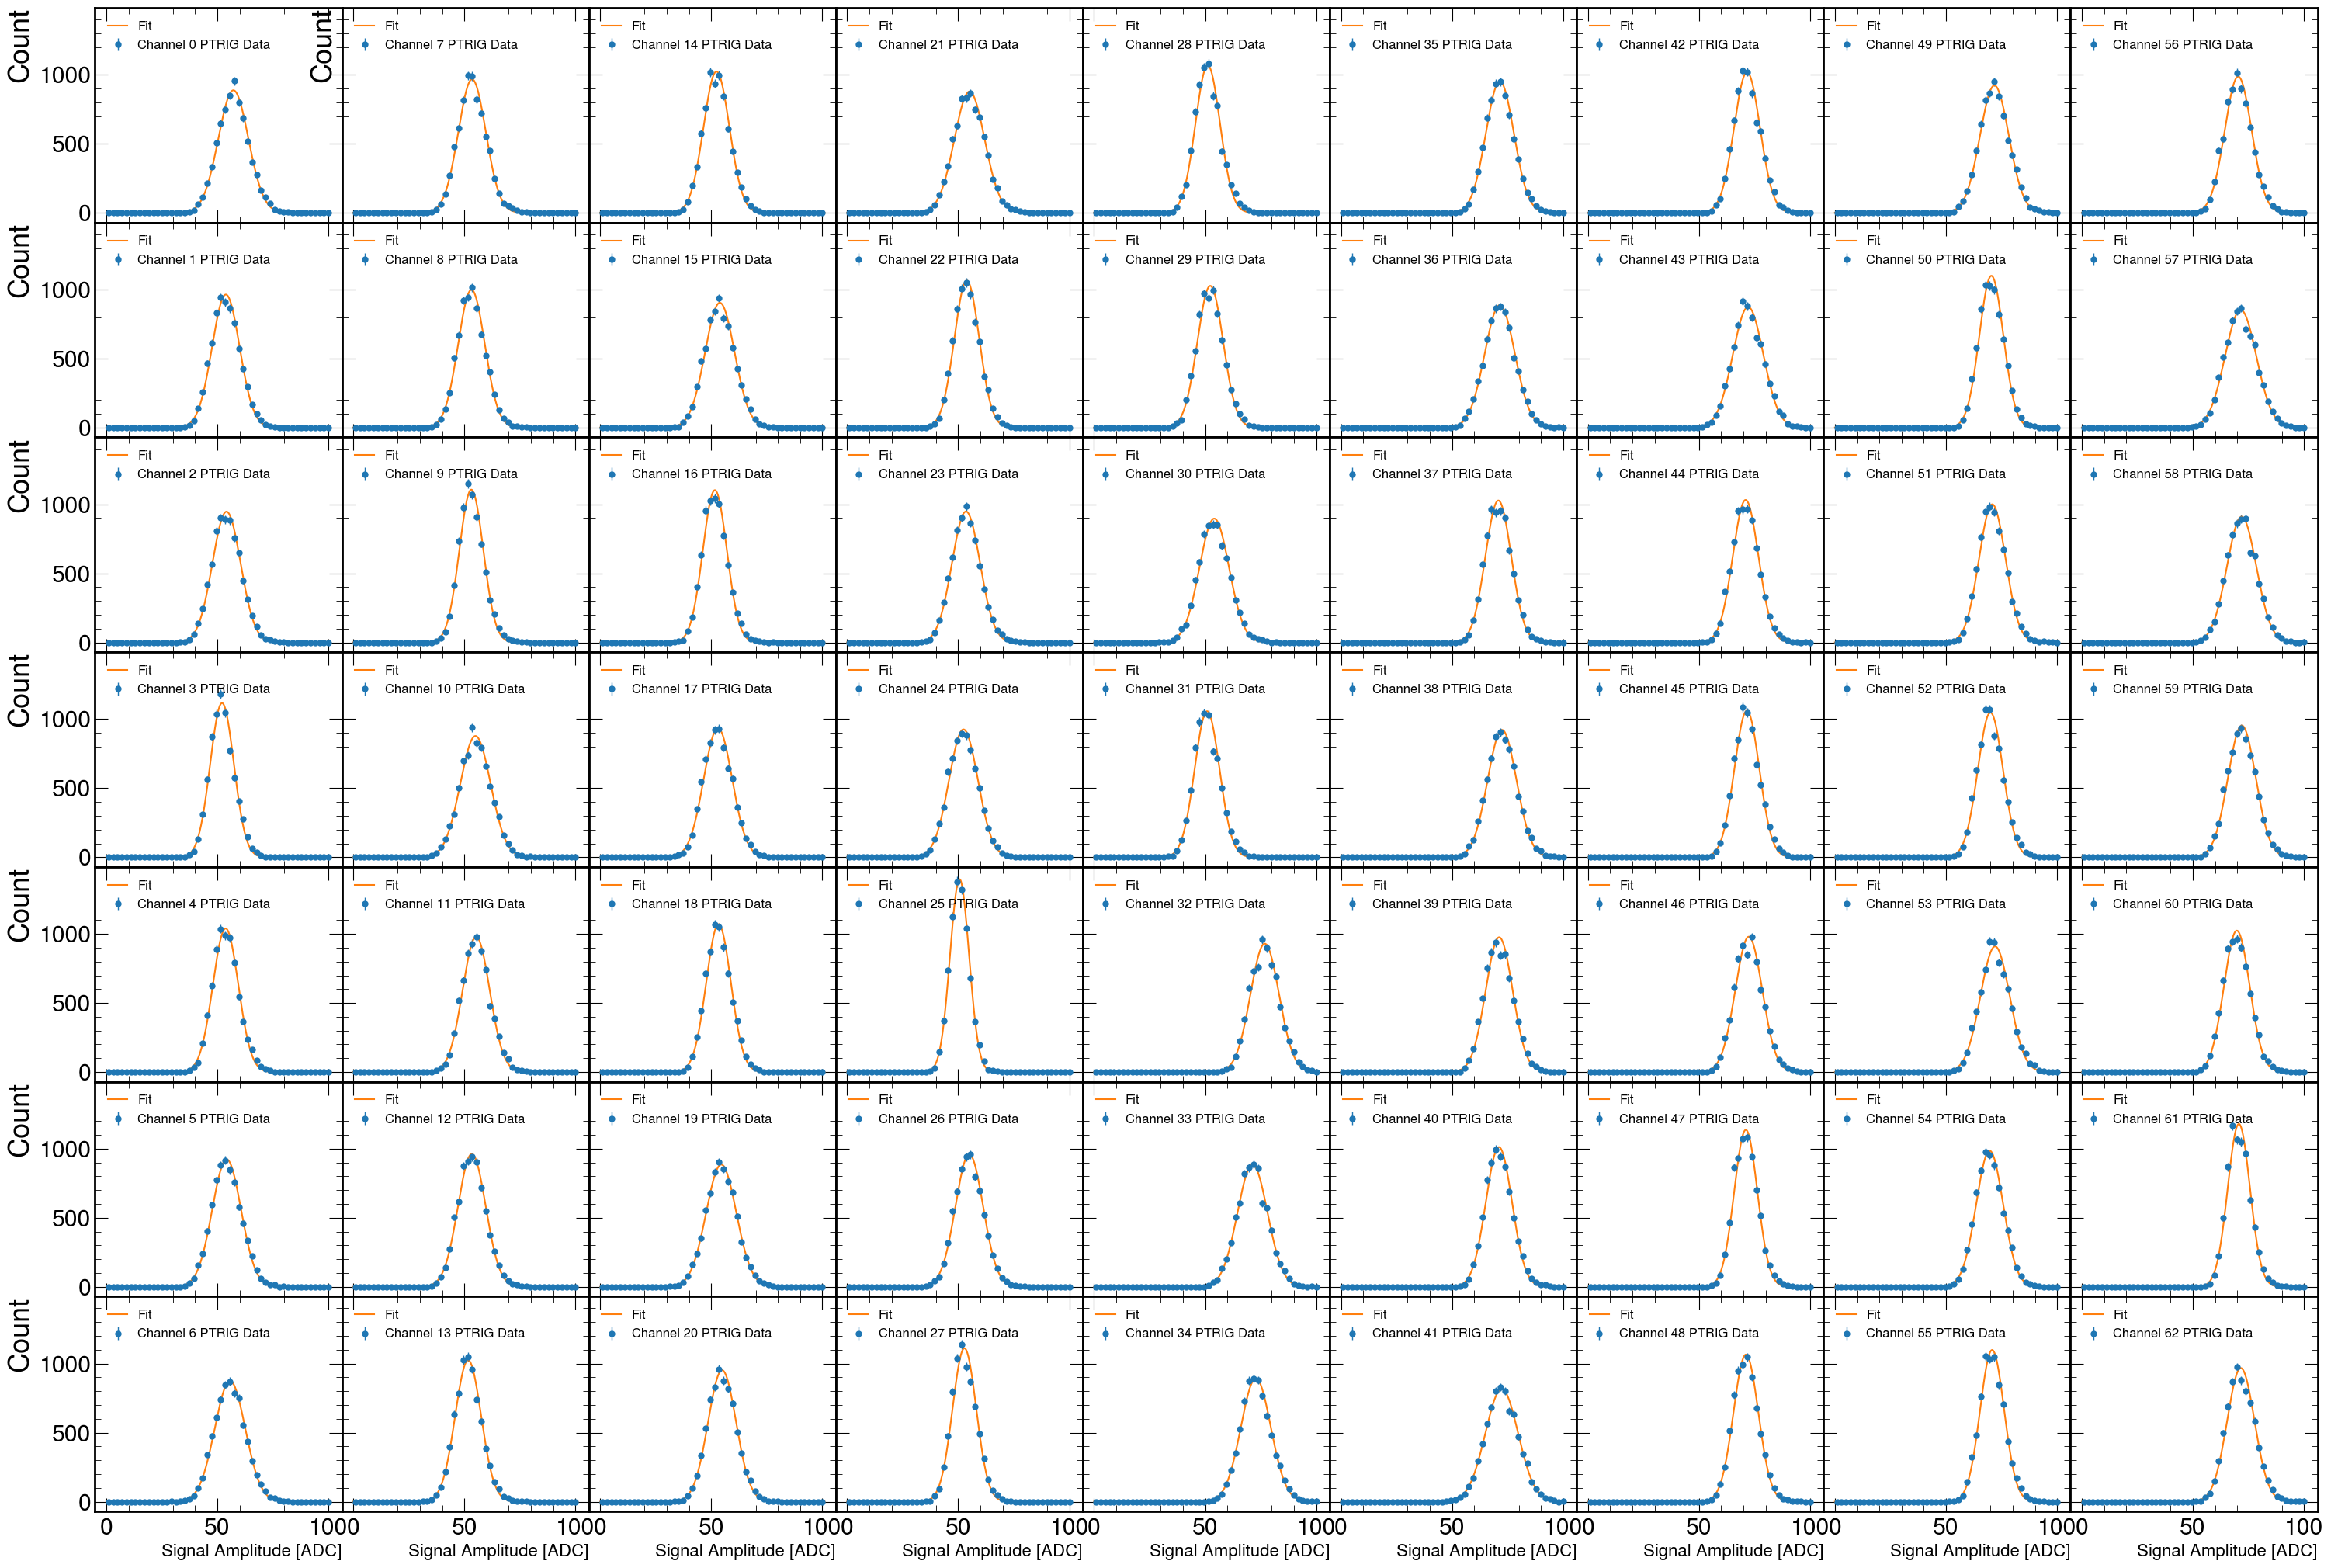

In [7]:
#Plot random trigger spectra for each low gain channel. 
#Fit to gaussian and record pedestals so that we can apply a cut later in the analysis

#Formating the output of the plots
#fig, axs=plt.subplots(4, 10, figsize=(0.5*len(df.columns),15),sharey=True,sharex=True)
fig, axs=plt.subplots(channels_per_board, number_of_boards, figsize=(30,20),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

#Defining the Gaussian function to fit to. 
#A is the amplitude, mu is the pedestal mean value, sigma is the pedestal standard deviation
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

#Defining the arrays of the pedestal means and the standard deviations. Values will be appended in the for loop below
pedMeans = []
pedStds = []
pedCount=[]

#Looping through each channel i
for i in range(channels_per_board*number_of_boards):
    plt.sca(axs[i%channels_per_board][i//channels_per_board])
    
    h = hist.Hist(hist.axis.Regular(50, 0, 101, name="Ptrig"))
    h.fill(np.array(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))))
    #h.plot(color='blue',label=f"Channel {i} PTRIG Data")  
    
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} PTRIG Data")

    # Initial parameter values for the fit
    initial_params = [max(h), sum(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i))))/len(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))), 2.5]
    #initial_params = [1000,53,2.5]
    # Create Minuit object and set up the fit
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = y>0
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    m = Minuit(LeastSquares(x, y, yerr, gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']

    
    x = np.linspace(0, 101, 1000)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper left', fontsize=12)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%7 == 0:
        plt.xlabel('Signal Amplitude [ADC]', fontsize=16)
    if i <= 7:
        plt.ylabel('Count')
  
    #plt.yscale("log") 
    
    pedMeans.append(mu_fit)
    pedStds.append(sigma_fit)
    pedCount.append(A_fit)
    

# Adjust the spacing between subplots
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

Creating a visual of the pedestal mean values and their average value overall. 

Average mean value:
62.328607374401074
Average width value:
6.092986340317066
Standard Deviation of mean values: 9.171705980214664


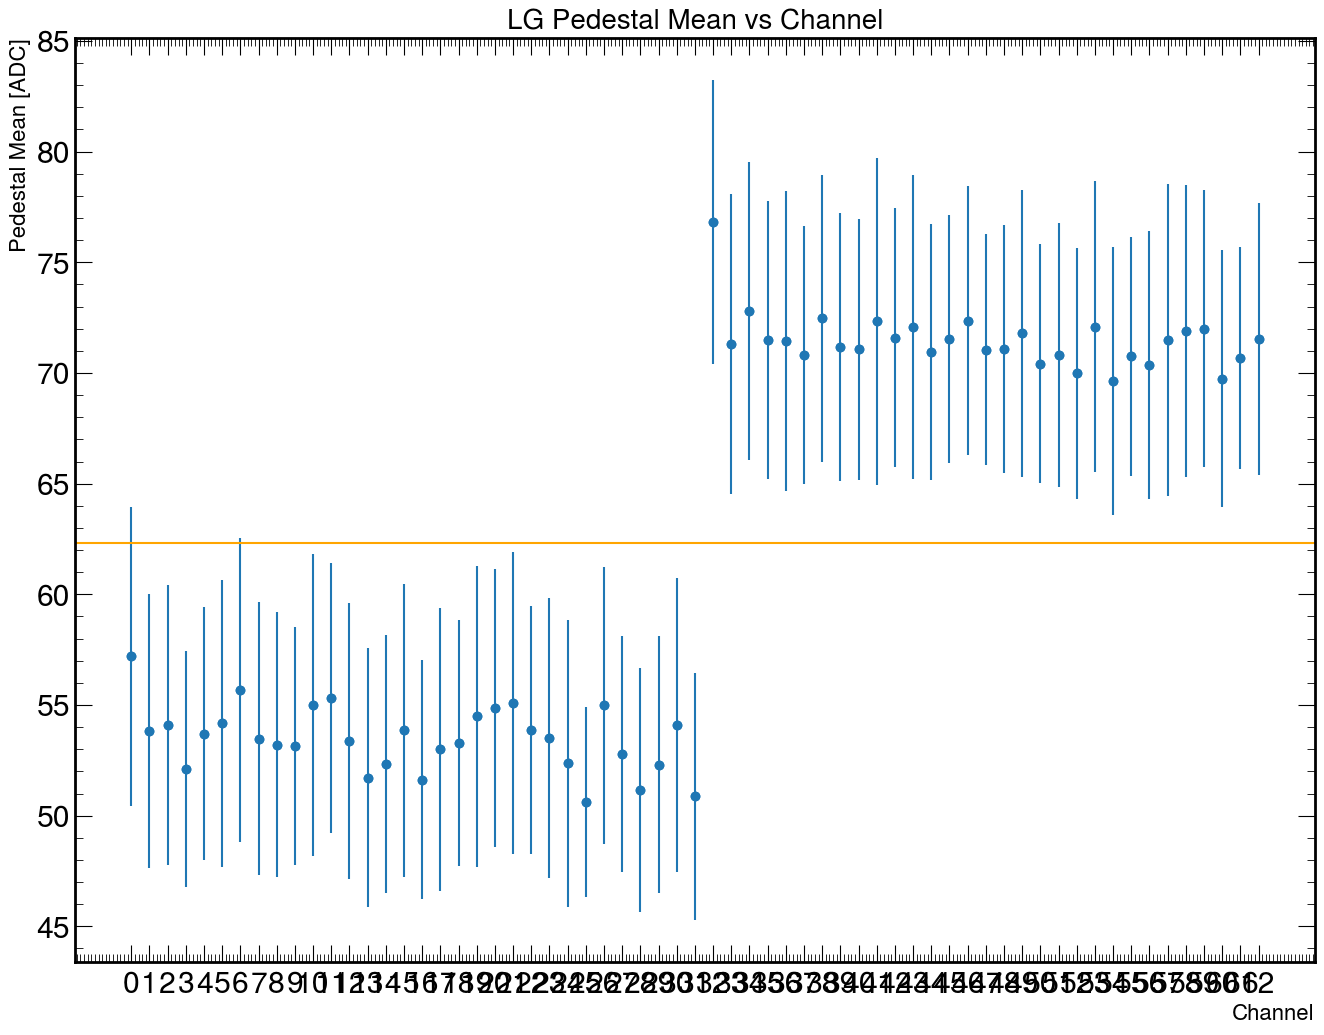

In [8]:
#Plotting pedestal means and stds for Low Gain
fig = plt.figure(figsize=(16, 12))
#print(len(pedMeans),channels_per_board*number_of_boards)
plt.scatter(range(0,channels_per_board*number_of_boards),pedMeans)
plt.xlabel('Channel', fontsize=16)
plt.ylabel('Pedestal Mean [ADC]', fontsize=16)
plt.title("LG Pedestal Mean vs Channel", fontsize=20)
plt.errorbar(range(0,channels_per_board*number_of_boards), pedMeans, yerr=pedStds, fmt="o")


#Geting the average value
avg = np.mean(pedMeans)

# Plot a horizontal line for the average
plt.axhline(y=avg, color='orange', label='Average')

x_ticks = np.arange(0, channels_per_board*number_of_boards, 1)
plt.xticks(x_ticks)

#Printing the Average pedestal mean value
print("Average mean value:")
print(np.mean(pedMeans))
print("Average width value:")
print(np.mean(pedStds))

#Printing the standard deviation of the pedMeans array
pedMeans_list = list(pedMeans)

# Calculate the standard deviation
pedMeans_stdev = statistics.stdev(pedMeans_list)

print("Standard Deviation of mean values:", pedMeans_stdev)
#print(pedMeans)
#print(pedStds)

## Cosmic Data
Subtracting the $(Pedestal Mean) + 4\sigma$ from the cosmic data, hence subtracting out the noise.\
Only selecting events in which cells directly in front and behind the cell in analysis are activated.\
Plotting the remaining data in a histogram and fitting to a landau to find. The mean value of the landau is the MIP value.

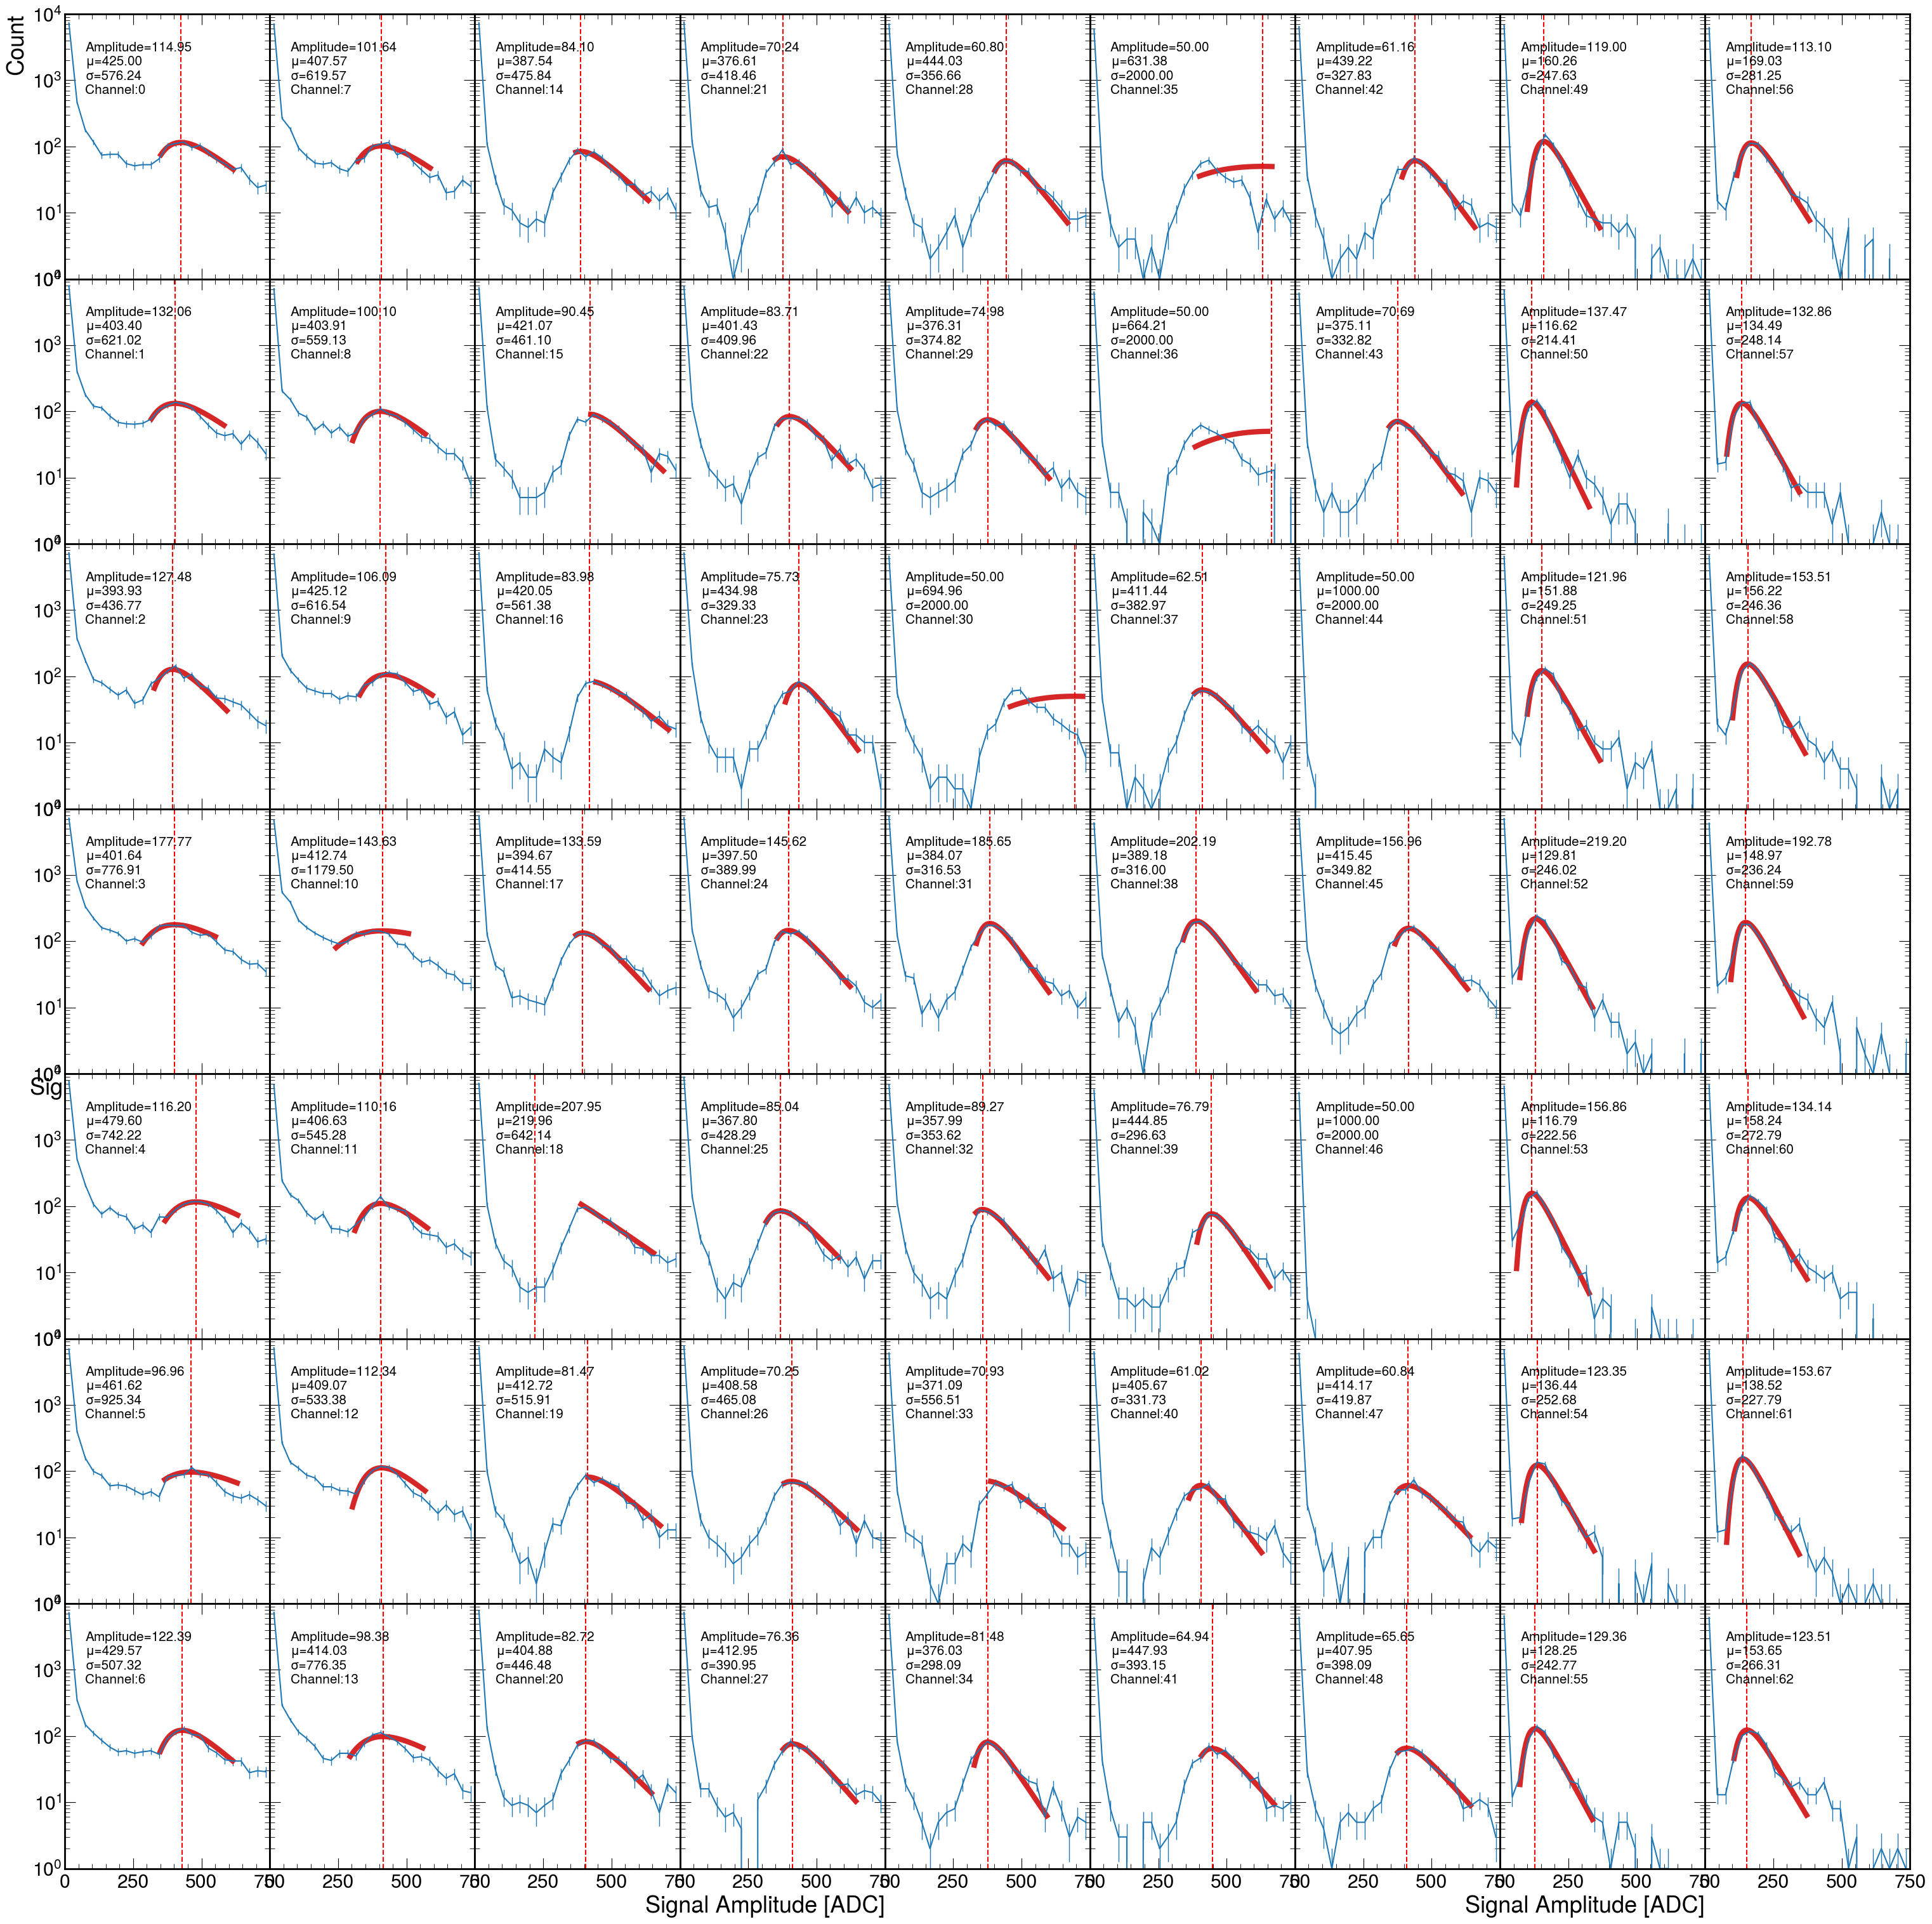

In [39]:
fig, axs=plt.subplots(channels_per_board, number_of_boards,figsize=(30,30),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
uc_means = []
uc_width = []
uc_mean_error = []
uc_width_error = []


def landau(x, A, mu, sigma):
    u = (x - mu)*3.591/(sigma/2.355)
    Aprime = 1.648*A
    return Aprime*np.exp((-u)/2 - np.exp(-u)/2)
    

def least_squares_landau(A, mu, sigma):
    y = landau(bins, A, mu, sigma)
    return np.sum((data - y)**2)

raw_mips = []
raw_mipStds = []

# Use to optimize the fit!!!
w_fit = 65


#for i in range(round(len(cosmicDF.columns)/2)):
for i in range(number_of_boards*channels_per_board):
    
    plt.sca(axs[i%channels_per_board][i//channels_per_board])
    
    h = hist.Hist(hist.axis.Regular(25, 0, 750, name="Ptrig"))
    hnocut = hist.Hist(hist.axis.Regular(25, 0, 750, name="Ptrig")) 
    cosmicCh = np.array(getattr(cosmicDF,"Ch_{}_LG".format("{:02d}".format(i))))
       ###################################################################################################
    
    cosmicCh = cosmicCh - pedMeans[i]
    cosmicChNoCut = cosmicCh
    cosmicCh = cosmicCh[cosmicCh >= (pedStds[i] *8)] 
    
    #cosmicCh = cosmicCh[cosmicCh >= (pedStds[i] * 4)+max_h_position[i]]
    #cosmicCh = cosmicCh - max_h_position[i]
       ###################################################################################################
    h.fill(cosmicCh)
    hnocut.fill(cosmicChNoCut)
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
  
    bins = bin_centers
    
    plt.errorbar(bins,hnocut.values()[()],yerr=np.sqrt(hnocut.values()[()]),fmt='-',ecolor='tab:blue', color='tab:blue', 
    capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} Cosmic Data")

    
    # Find the bin number with the maximum value
    max_bin_number = np.argmax(h.values())
    histMode = np.median(cosmicCh)
    
    # Get the axis from the histogram
    axis = h.axes[0]

    # Find the x-coordinate corresponding to the maximum bin
    #x_coordinate = axis.edges[max_bin_number]
    x_coordinate = histMode
    #mips.append(x_coordinate)
    #x_value = bins[max_bin_number]
    x_value = histMode
    # Initial parameter values for the fit
    initial_params = [max(h), np.mean(cosmicCh), np.std(cosmicCh)]
    #initial_params = [2000, 30, np.std(cosmicCh)]
    # Create Minuit object and set up the fit
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = (bins>(x_value - w_fit-25)) & (bins<(x_value + w_fit + 30)) & (data > 0)
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    cost = LeastSquares(x, y, yerr, landau)
    uc_m = Minuit(cost, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    uc_m.limits["A"] = (50,4000)
    uc_m.limits["sigma"] = (10, 2000)
    uc_m.limits["mu"] = (50, 1000) 
            

    # Perform the fit

    uc_m.migrad()
    # Get the fitted parameters
    fitted_params = uc_m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    
    uc_x = np.linspace(x_value-w_fit-15, x_value+w_fit + 120, 50)
    #uc_x = np.linspace(0,450,100)

    #print(x_value-w_fit,' ',x_value+w_fit)
    y_fit = landau(uc_x, A_fit, mu_fit, sigma_fit)
    plt.plot(uc_x, y_fit, 'tab:red', label='Fit',linewidth = 6)

    #plt.legend(loc='upper right', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 0:
        plt.ylabel('Count')
    
    raw_mips.append(mu_fit)
    raw_mipStds.append(sigma_fit)
    annotation_text = f"Amplitude={A_fit:.2f}\n\u03bc={mu_fit:.2f}\n\u03c3={sigma_fit:.2f}\nChannel:{i}"
    plt.annotate(annotation_text, xy=(0.1, 0.7), xycoords='axes fraction', fontsize=15, color='black')
    
    uc_means.append(fitted_params[1])
    uc_width.append(fitted_params[2])
    uc_mean_error.append(uc_m.errors[1])
    uc_width_error.append(uc_m.errors[2])
    
    #calculating chisquare 
    lower_x = x_value - w_fit  # Lower bound of the range
    upper_x = x_value + w_fit  # Upper bound of the range
    count = np.sum((bins >= lower_x) & (bins <= upper_x))

    # Calculate chi-square
    observed_data = data[(bins >= lower_x) & (bins <= upper_x)]
    expected_data = landau(bins[(bins >= lower_x) & (bins <= upper_x)], A_fit, mu_fit, sigma_fit)
    chi_square = np.sum((observed_data - expected_data) ** 2 / expected_data)

    # Print the count and chi-square value
    #print(f"Number of data points in the range {lower_x} to {upper_x}: {count}")
    #print(chi_square/3,',')

    #print(x_value)
    plt.axvline(x=mu_fit, color='red', linestyle='--', label=f"Vertical Line at x={x_value}")
    #if i==1:
    #    plt.title("Cable Length: 0.7 Meters\n",loc='right')
# Adjust the spacing between subplots

#plt.ylim(0,2500)
plt.xlim(0,750)
plt.yscale('log')
plt.tight_layout(pad=0.0)
plt.ylim(10**0,10**4)
plt.subplots_adjust(hspace=0.0, wspace=0.0)



plt.savefig('boardscosmic5.png')
plt.show()

In [12]:
# #Reading in the ptrig data f
# from CableLength import Analysis

# Analysis(r'PTRIG_LG50_HG50_4k_R44_1.pkl',r'COSMIC_LG50_HG50_4k_R43_1.pkl')


[422.04486239 414.43020905 396.04665541 384.60339505 497.43186956
 489.3682383  450.87861969]
[497.43186956 489.3682383  450.87861969 409.59392628 438.31242891
 468.62494496 317.02183052]
[438.31242891 468.62494496 317.02183052 420.40791209 475.77902316
 432.42285217 393.57817837]
[475.77902316 432.42285217 393.57817837 441.68073055 408.94674773
 394.63229381 389.39019346]
[408.94674773 394.63229381 389.39019346 413.25443877 406.65002789
 376.61359089 396.57425807]
[406.65002789 376.61359089 396.57425807 422.46353498 395.48335637
 367.54418305 408.41334606]
[395.48335637 367.54418305 408.41334606 410.63557013 441.28662115
 377.30396825 478.84029255]
[441.28662115 377.30396825 478.84029255 377.94823559 364.26870655
 420.34615297 367.77455036]
[364.26870655 420.34615297 367.77455036 422.81716582 410.74673186
 411.4428703  389.18867746]
[410.74673186 411.4428703  389.18867746 435.94321065 393.8838974
 447.24645094 424.42536165]
[393.8838974  447.24645094 424.42536165 375.13014453 599.9997

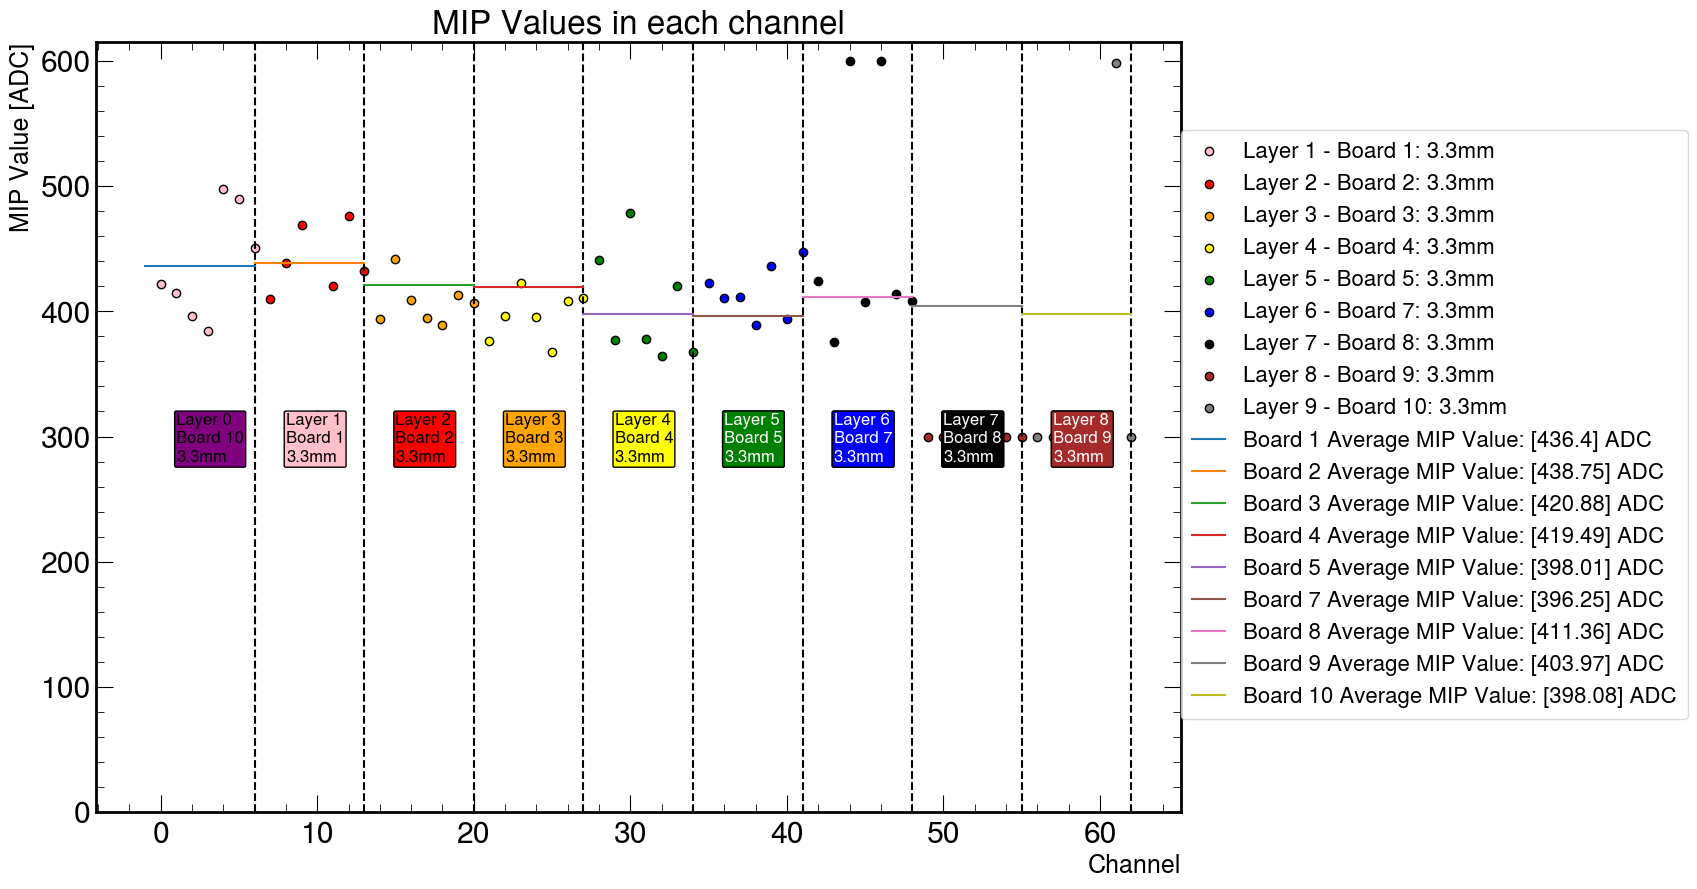

In [15]:
from statistics import mean
raw_mips = np.array(raw_mips)
averages=[]

#print(raw_mips)

for i in range(len(raw_mips)):
    if i%4==0:
        print (raw_mips[i:i+channels_per_board])
        averages.append([mean(raw_mips[i:i+channels_per_board])]) 

#print (averages)
    
    

fig = plt.figure( figsize=(7*2, 5*2))
colors=['pink','red','orange','yellow','green','blue','black','brown','grey','purple']
board_number=[1,2,3,4,5,7,8,9,10]
sipm_size=['3.3mm','3.3mm','3.3mm','3.3mm','3.3mm','3.3mm','3.3mm','3.3mm','3.3mm','3.3mm']
ii=0
flag=False

for i in range(channels_per_board*number_of_boards):
    #if i in (100,102): #ignore
     #   flag=True
        #plt.annotate('Dead Channel',(i,raw_mips[i]),fontsize=10)
    if not flag:
        if (i+1)%channels_per_board==0:
            
            plt.scatter(i,raw_mips[i],c=colors[ii],edgecolors='black',label=f'Layer {ii+1} - Board {board_number[ii]}: {sipm_size[ii]}')
            ii=ii+1
        else:
            plt.scatter(i,raw_mips[i],c=colors[ii],edgecolors='black')
    
    else:
        flag=False
#plt.scatter(range(0,63),raw_mips,c='red')

ii=-1
for i in range(channels_per_board*number_of_boards):
    
    if (i+1)%channels_per_board==0:
        
        plt.axvline(x = i, color = 'black',ls='--')
        plt.errorbar([i-channels_per_board,i],[averages[ii+1],averages[ii+1]],label=f'Board {board_number[ii+1]} Average MIP Value: {np.round(averages[ii+1],2)} ADC')
        plt.annotate(f'Layer {ii+1}\nBoard {board_number[ii]}\n{sipm_size[ii]}',(i-5,280),c='black',fontsize=12,bbox=dict(boxstyle='round,pad=0.1',edgecolor='black',facecolor=colors[ii]))
        if ii>3:
            plt.annotate(f'Layer {ii+1}\nBoard {board_number[ii]}\n{sipm_size[ii]}',(i-5,280),c='white',fontsize=12,bbox=dict(boxstyle='round,pad=0.1',edgecolor='black',facecolor=colors[ii]))

        ii=ii+1

#plt.axvline(x = 7, color = 'b', label = 'axvline - full height')
plt.ylim(0)
plt.xlabel('Channel', fontsize=18,loc='right')
plt.ylabel('MIP Value [ADC]', fontsize=18)
plt.title('MIP Values in each channel', fontsize = 24)
plt.legend(frameon='True',bbox_to_anchor=(0.99,0.9))
#plt.errorbar(range(0,21), raw_mipStds, yerr=raw_mipStds, fmt="o")

# print("Average mean value:")
# print(np.mean(raw_mips))
# print("Average width value:")
# print(np.mean(raw_mipStds))

plt.savefig('MIPValues.png')
plt.show()

#NOTE THAT BOARD 48 is not show because it is a 7 channel board